Selecting files from the alignment and convert to counts

In [6]:
%%bash 
  # featurecounts from bioconda subread
# Define paths
ALIGNED_DIR="data/alignment_STAR_subset/"  
OUTPUT_DIR="data/gene_counts_DESeq"  # Define output directory
GTF_FILE="/human_genome/cleaned_Homo_sapiens.GRCh38.113.gtf"  # GTF annotation file

# Create output directory 
mkdir -p "$OUTPUT_DIR"

# Loop through BAM files
for file in ${ALIGNED_DIR}/*sortedByCoord.out.bam; do
    # Extract sample name
    SAMPLE=$(basename "$file" _Aligned.sortedByCoord.out.bam)

    # Run featureCounts
    featureCounts -T 8 \
        -a "human_genome/Homo_sapiens.GRCh38.113.gtf" \
        -o "${OUTPUT_DIR}/${SAMPLE}.counts.txt" \
        -g gene_id \
        -t exon \
        -s 0 \
        -p \
        "$file"
done



/usr/share/lmod/lmod/init/bash: /usr/share/lmod/lmod/libexec/addto: /usr/bin/lua: bad interpreter: No such file or directory

        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
	  v2.0.8

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 1 BAM file                                       ||
||                                                                            ||
||                           ERR950158_trimmed_Aligned.sortedByCoord.out.bam  ||
||                   

merge all files into a count matrix

In [12]:
import os
import pandas as pd

# Define directory
count_dir = "data/gene_counts_DESeq/"

# List all count files
count_files = [f for f in os.listdir(count_dir) if f.endswith("trimmed.counts.txt")]

# Read and merge count files
dfs = []
for file in count_files:
    df = pd.read_csv(os.path.join(count_dir, file), sep="\t", skiprows=1, usecols=[0, 6])  # Geneid & counts
    sample_name = file.replace("trimmed.counts.txt", "")
    df.rename(columns={df.columns[1]: sample_name}, inplace=True)
    dfs.append(df)

# Merge all dataframes
merged_counts = dfs[0]
for df in dfs[1:]:
    merged_counts = merged_counts.merge(df, on="Geneid", how="outer")

# Save merged file
merged_counts.to_csv("merged_counts_matrix.csv", index=False)




Merged count matrix saved as 'merged_counts_matrix.csv'.


Run DESeq2

In [24]:
%%R
#import rpy2.robjects as robjects

#r_deseq_script = """
library(DESeq2)                                              

# Load count matrix
count_matrix <- read.table("data/STAR_DE_analysis/STAR_merged_counts.txt",  header = TRUE, sep = "\t", row.names=1)
#count_matrix <- count_matrix[, -1]
metadata <- read.table("data/STAR_DE_analysis/STAR_metadata.txt", header = TRUE)
count_matrix <- as.matrix(count_matrix)
mode(count_matrix) <- "numeric"


rownames(metadata) <- metadata$Sample_ID

#create the factors from diagnosis
metadata$Diagnosis <- factor(metadata$Diagnosis, levels = c("Atr", "Hp"))

samples <- rownames(metadata)

# Keep only samples present in both metadata and count matrix
samples <- intersect(samples, colnames(count_matrix))

count_matrix <- count_matrix[, samples]
metadata <- metadata[samples, , drop = FALSE]

# Create DESeq2 data
dds <- DESeqDataSetFromMatrix(countData = as.matrix(count_matrix), colData = metadata, design = ~ Diagnosis)

# Run DESeq2
dds <- DESeq(dds)

# Extract results
res <- results(dds, contrast = c("Diagnosis", "Hp", "Atr"))

# Save results
write.csv(res, "STAR.DESeq2_results.csv")
#"""

# Run DESeq2 inside Python
#robjects.r(r_deseq_script)




R[write to console]: Loading required package: S4Vectors

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: 
Attaching package: 'BiocGenerics'


R[write to console]: The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min


R[write to console]: 
Attaching package: 'S4Vectors'


R[write to console]: The following object is masked from 'package:utils':

    findMatches


R[write to console]: The following 

In [20]:
%reload_ext rpy2.ipython

In [34]:
#import rpy2.robjects as robjects
%%R
#r_deseq_script = """
library(DESeq2)                                              

#Try the deseq analysis using the subread data
# Load count matrix
count_matrix <- read.csv("data/merged_counts_matrix.csv",  header = TRUE, sep = ",", check.names = FALSE)
str(count_matrix)
#count_matrix <- count_matrix[, -1]
metadata <- read.table("data/STAR_DE_analysis/STAR_metadata.txt", header = TRUE, sep = "\t")
#count_matrix <- as.matrix(count_matrix)
mode(count_matrix) <- "numeric"

rownames(metadata) <- metadata$Sample_ID

#create the factors from diagnosis
metadata$Diagnosis <- factor(metadata$Diagnosis, levels = c("Atr", "Hp"))

samples <- rownames(metadata)

# Keep only samples present in both metadata and count matrix
samples <- intersect(samples, colnames(count_matrix))

count_matrix <- count_matrix[, samples]
metadata <- metadata[samples, , drop = FALSE]

# Create DESeq2 data
dds <- DESeqDataSetFromMatrix(countData = as.matrix(count_matrix), colData = metadata, design = ~ Diagnosis)

# Run DESeq2
dds <- DESeq(dds)

# Extract results
res <- results(dds, contrast = c("Diagnosis", "Hp", "Atr"))

# Save results
write.csv(res, "STAR.DESeq2.subread_results.csv")
#"""

# Run DESeq2 inside Python
#robjects.r(r_deseq_script)

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (415131307.py, line 8)

# Clean DESeq2 code 

In [2]:
%reload_ext rpy2.ipython

In [4]:
%%R
library(DESeq2)                                              

# Load count matrix
count_matrix <- read.table("data/STAR_DE_analysis/STAR_merged_counts.txt",  header = TRUE, sep = "\t", row.names=1)
metadata <- read.table("data/STAR_DE_analysis/STAR_metadata.txt", header = TRUE)
count_matrix <- as.matrix(count_matrix)
mode(count_matrix) <- "numeric" #have  to specify that the matrix is integers. 

rownames(metadata) <- metadata$Sample_ID #defining the names of the rows in metadata

#create the factors from diagnosis
metadata$Diagnosis <- factor(metadata$Diagnosis, levels = c("Hp", "Atr"))

samples <- rownames(metadata)

# Keep only samples present in both metadata and count matrix
samples <- intersect(samples, colnames(count_matrix))

count_matrix <- count_matrix[, samples]
metadata <- metadata[samples, , drop = FALSE]

# Create DESeq2 data
dds <- DESeqDataSetFromMatrix(countData = as.matrix(count_matrix), colData = metadata, design = ~ Diagnosis)

# Run DESeq2
dds <- DESeq(dds)

# Extract results
res <- results(dds, contrast = c("Diagnosis", "Atr", "Hp"))
write.csv(res, "STAR.DESeq2_results.csv")
res_sig <- res[which(res$padj < 0.05), ]

# Save filtered results
write.csv(res_sig, "STAR_DESeq2_Results.csv")

# Save results

R[write to console]: Loading required package: S4Vectors

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: 
Attaching package: 'BiocGenerics'


R[write to console]: The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min


R[write to console]: 
Attaching package: 'S4Vectors'


R[write to console]: The following object is masked from 'package:utils':

    findMatches


R[write to console]: The following 

In [ ]:
%%bash
#moves STAR_edgeR_Results.csv into the STAR_DE_analysis directory
group_dir='/cephyr/NOBACKUP/groups/bbt045_2025/groups/group_Bjork/'
STAR_DE_analysis_dir='/cephyr/NOBACKUP/groups/bbt045_2025/groups/group_Bjork/data/STAR_DE_analysis'
mv $group_dir/STAR_DESeq2_Results.csv $STAR_DE_analysis_dir/STAR_DESeq2_Results.csv 

In [86]:
%%bash
cd /cephyr/NOBACKUP/groups/bbt045_2025/groups/group_Bjork/data/STAR_DE_analysis
chmod -R 777 STAR_DESeq2_Results.csv

/usr/share/lmod/lmod/init/bash: /usr/share/lmod/lmod/libexec/addto: /usr/bin/lua: bad interpreter: No such file or directory


# filter results using python

In [1]:
import pandas as pd
DESeq2_STAR_results = pd.read_csv("STAR.DESeq2_results.csv") 

DESeq2_STAR_results = DESeq2_STAR_results.dropna(subset=["padj"]) #drop all NAN in padj column

DESeq2_STAR_filtered_results = DESeq2_STAR_results.sort_values("padj", ascending=True) 
#print(DESeq2_STAR_filtered_results.loc[DESeq2_STAR_filtered_results["padj"]<=0.01])
print(len(DESeq2_STAR_filtered_results[DESeq2_STAR_filtered_results["padj"] <0.05]))
DESeq2_STAR_significant_genes = DESeq2_STAR_filtered_results[DESeq2_STAR_filtered_results["padj"]<=0.05]
DESeq2_STAR_significant_genes.iloc[1:10]
print(len(DESeq2_STAR_filtered_results))

2064
29338


>Very many significant, seems unlikely


In [2]:
%load_ext rpy2.ipython

In [12]:
%%R
# Load necessary libraries
library(ggplot2)

# Load DESeq2 results
DESeq2_results <- read.csv("STAR.DESeq2_results.csv", header = TRUE)

# Ensure required columns exist
if (!("log2FoldChange" %in% colnames(DESeq2_results)) | !("padj" %in% colnames(DESeq2_results))) {
  stop("Error: 'log2FoldChange' or 'padj' column is missing in the data.")
}

# Convert padj to -log10(padj) for plotting
DESeq2_results$neg_log10_padj <- -log10(DESeq2_results$padj)

# Define significance thresholds
DESeq2_results$Significance <- ifelse(DESeq2_results$padj < 0.05 & abs(DESeq2_results$log2FoldChange) > 1, "Significant", "Not Significant")

# Create volcano plot
volcano_plot <- ggplot(DESeq2_results, aes(x = log2FoldChange, y = neg_log10_padj, color = Significance)) +
  geom_point(alpha = 0.8) +
  scale_color_manual(values = c("Significant" = "red", "Not Significant" = "grey")) +
  theme_minimal() +
  xlab("Log2 Fold Change") +
  ylab("-Log10 Adjusted P-Value") +
  ggtitle("Volcano Plot of DESeq2 Results") +
  geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "blue") +
  geom_vline(xintercept = c(-1, 1), linetype = "dashed", color = "black")

# Display plot
png("DEseq_volcanoplot.png")
print(volcano_plot)
dev.off()

png 
  2 


# dispersion plot

`geom_smooth()` using formula = 'y ~ x'


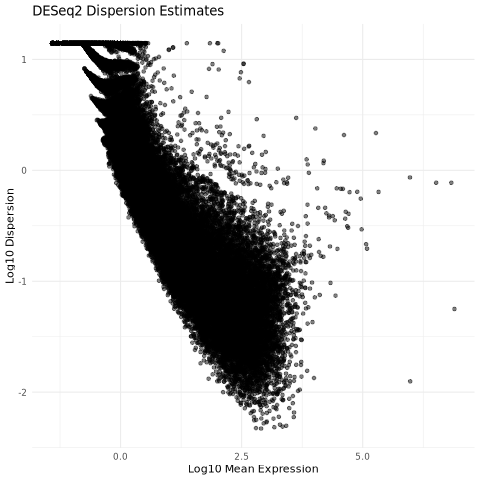

In [25]:
%%R
disp_table <- data.frame(
  mean_expression = rowMeans(counts(dds, normalized = TRUE)),  # Mean normalized count per gene
  dispersion = dispersions(dds)  # Dispersion values per gene
)

# Dispersion Plot using ggplot2
ggplot(disp_table, aes(x = log10(mean_expression), y = log10(dispersion))) +
  geom_point(alpha = 0.5) +
  geom_smooth(method = "loess", col = "blue") +
  theme_minimal() +
  xlab("Log10 Mean Expression") +
  ylab("Log10 Dispersion") +
  ggtitle("DESeq2 Dispersion Estimates")

In [11]:
%%R
library(DESeq2)
png("DESeq_dispersion.png")
plotDispEsts(dds)
dev.off()

png 
  2 


R[write to console]: Error in title(...) : 
  cannot coerce type 'closure' to vector of type 'character'




Error in title(...) : 
  cannot coerce type 'closure' to vector of type 'character'


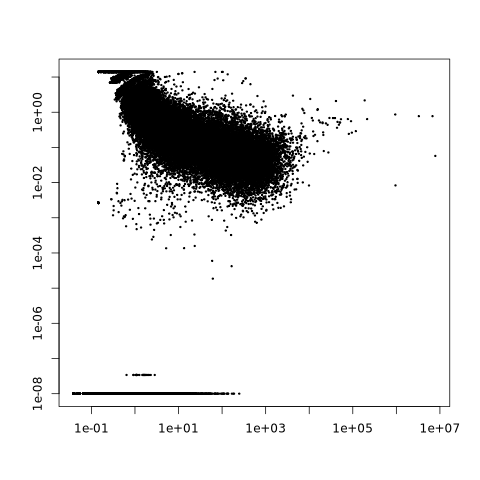

RInterpreterError: Failed to parse and evaluate line 'plotDispEsts(\n      dds,\n      0,\n      CV = FALSE,\n      genecol = "black",\n      fitcol = "red",\n      finalcol = "dodgerblue",\n      legend = TRUE,\n      xlab,\n      ylab,\n      log = "xy",\n      cex = 0.45,\n      \n)\n'.
R error message: "Error in title(...) : \n  cannot coerce type 'closure' to vector of type 'character'"

In [64]:
%%R
plotDispEsts(
      dds,
      0,
      CV = FALSE,
      genecol = "black",
      fitcol = "red",
      finalcol = "dodgerblue",
      legend = TRUE,
      xlab,
      ylab,
      log = "xy",
      cex = 0.45,
      
)

R[write to console]: using ntop=500 top features by variance



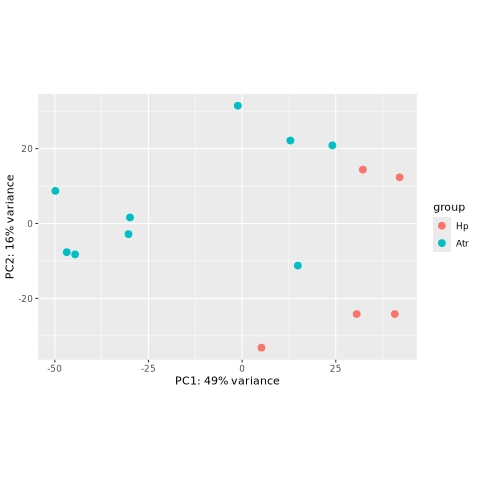

In [6]:
%%R
#png("DESeq_PCA.png")
DESeq2transform = normTransform(dds, f = log2, pc = 1)

plotPCA(
      DESeq2transform,
      intgroup = "Diagnosis",
      ntop = 500,
      returnData = FALSE,
      pcsToUse = 1:2
)
#dev.off()

R[write to console]: using ntop=500 top features by variance



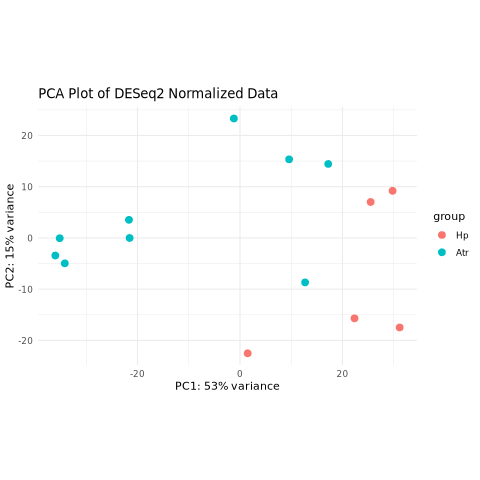

In [7]:
%%R
# Load required libraries
library(DESeq2)
library(ggplot2)

# Perform Variance Stabilizing Transformation (VST) for PCA
DESeq2transform <- vst(dds, blind = TRUE)

# Open PNG file for output
#png("DESeq_PCA.png", width = 800, height = 600)

# PCA plot
pca_plot <- plotPCA(DESeq2transform, intgroup = "Diagnosis") +
  ggtitle("PCA Plot of DESeq2 Normalized Data") +
  theme_minimal()

print(pca_plot)

# Close PNG file
#dev.off()


png 
  2 


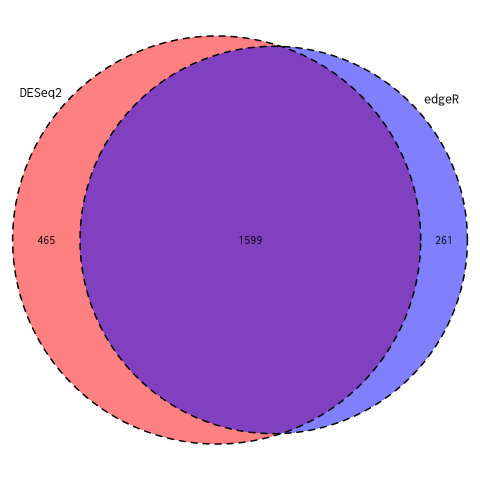

In [8]:
%%R
# Load necessary libraries
library(VennDiagram)

# Load significant DESeq2 results from two files
sig_genes1 <- read.csv("data/STAR_DE_analysis/STAR_DESeq2_Results.csv", header = TRUE)
sig_genes2 <- read.table("data/STAR_DE_analysis/STAR_edgeR_Results.csv", header = TRUE, sep="\t")

# Extract gene names (assuming Gene IDs are in the first column)
genes1 <- as.character(sig_genes1[,1])
genes2 <- as.character(sig_genes2[,1])

# Create a Venn diagram
venn.plot <- draw.pairwise.venn(
  area1 = length(genes1),
  area2 = length(genes2),
  cross.area = length(intersect(genes1, genes2)),
  category = c("DESeq2", "edgeR"),
  fill = c("red", "blue"),
  alpha = 0.5,
  lty = "dashed",
  cat.cex = 1.2,
  main = "Overlap of Significant Genes"
)

# Save the Venn diagram
png("VennDiagram_SignificantGenes.png")
grid.draw(venn.plot)
dev.off()


In [ ]:
%%R
